In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
plt.style.use('ggplot')

In [2]:
# 데이터 불러오기
apart_df = pd.read_csv('../data/new_apart_data_preprocessing_outlier.csv')
apart_df.head()

,Unnamed: 0,receipt_year,gu_name,dong_name,main_lot_num,sub_lot_num,arch_area,floor,arch_year,building_usage,...,pyeong_group,price_euk,price_per_pyeong,contract_year,contract_month,subway_line,subway_name,school_type,landing_rate,deposit_rate
0,0,2025,11,253,365.0,4.0,51.07,7,2013.0,0,...,1,3.88,2511.542252,2025,6,1.0,17,5,4.0,2.97
1,1,2025,1,191,447.0,0.0,84.98,9,1987.0,0,...,2,52.00,20228.386261,2025,6,2.0,13,5,4.0,2.97
2,2,2025,1,8,1282.0,0.0,84.90,28,2020.0,0,...,2,32.00,12459.967487,2025,6,2.0,13,5,4.0,2.97
3,3,2025,16,23,1500.0,0.0,84.45,12,2001.0,0,...,2,13.75,5382.421013,2025,6,2.0,14,5,4.0,2.97
4,4,2025,4,315,1165.0,0.0,84.99,13,2015.0,0,...,2,9.70,3772.928074,2025,6,5.0,9,4,4.0,2.97


In [3]:
apart_df.drop(columns=['Unnamed: 0','building_usage','deal_type', 'contract_month', 'contract_year','arch_decade', 'subway_line', 'floor', 'sub_lot_num', 'main_lot_num', 'price_per_pyeong' ], inplace=True)

In [4]:
apart_df.columns

Index(['receipt_year', 'gu_name', 'dong_name', 'arch_area', 'arch_year',
       'pyeong', 'pyeong_group', 'price_euk', 'subway_name', 'school_type',
       'landing_rate', 'deposit_rate'],
      dtype='object')

In [5]:
# 2022~2024년 데이터를 테스트셋으로, 나머지를 훈련셋으로 분리
train_df = apart_df[~apart_df['receipt_year'].isin([2022, 2023, 2024])]
test_df = apart_df[apart_df['receipt_year'].isin([2022, 2023, 2024])]

# X, y 분리
X_train = train_df.drop('price_euk', axis=1).select_dtypes(include=['number'])
y_train = train_df['price_euk']

X_test = test_df.drop('price_euk', axis=1).select_dtypes(include=['number'])
y_test = test_df['price_euk']

# 년도로 분리해서 사용할 땐 무작위로 섞는건 의미 없음

In [ ]:
# 파이프라인 정의
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

numerical_features = ['arch_area', 'arch_year', 'pyeong', 'subway_name','landing_rate', 'deposit_rate']
categorical_features = X_train.drop(numerical_features, axis=1).columns

# 전처리 파이프라인
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ("num", StandardScaler(), numerical_features)
        ], 
        remainder="passthrough")


pipe_random = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor())])

pipe_kneighbors = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', KNeighborsRegressor())])

pipe_decision = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', DecisionTreeRegressor(max_depth=5))])

pipe_XGboost = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5))])

pipe_LightGBM = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=5))])

pipe_CatBoost = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, verbose=0))])

pipes = [pipe_random, pipe_kneighbors, pipe_decision, pipe_XGboost, pipe_LightGBM, pipe_CatBoost]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score

models = ['랜덤 포레스트', 'kNeighbors', 'DecisionTree', 'XGboost', 'LightGBM', 'CatBoost']

for pipe in pipes:
    
    model = pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    rmse = root_mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)

    if pipe == pipes[0]:
        print(f'==={models[0]} 모델의 평가결과=====')
    elif pipe == pipes[1]:
        print(f'==={models[1]} 모델의 평가결과=====')
    elif pipe == pipes[2]:
        print(f'==={models[2]} 모델의 평가결과===')
    elif pipe == pipes[3]:
        print(f'==={models[3]} 모델의 평가결과===')    
    elif pipe == pipes[4]:
        print(f'==={models[4]} 모델의 평가결과===')    
    elif pipe == pipes[5]:
        print(f'==={models[5]} 모델의 평가결과===')    
    print(f'R2:{r2:.4f}')
    print(f'RMSE:{rmse:.4f}')
    print(f'MAE:{mae:.4f}')
    print(f'MSE:{mse:.4f}')
    print(f'Score:{pipe.score(X_train, y_train)}')
    print('==================================')
    print('')

===랜덤 포레스트 모델의 평가결과=====
R2:0.8881
RMSE:2.8795
MAE:1.4681
MSE:8.2917
Score:0.9928870968161487

===kNeighbors 모델의 평가결과=====
R2:0.5841
RMSE:5.5514
MAE:3.4277
MSE:30.8176
Score:0.9313158626747525

===DecisionTree 모델의 평가결과===
R2:0.5844
RMSE:5.5489
MAE:3.6854
MSE:30.7905
Score:0.6521539864315288

===XGboost 모델의 평가결과===
R2:0.8543
RMSE:3.2861
MAE:2.0521
MSE:10.7985
Score:0.9223179888253848

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1076
[LightGBM] [Info] Number of data points in the train set: 31441, number of used features: 236
[LightGBM] [Info] Start training from score 12.986178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/jeon-yeongnam/Desktop/project/1st-project-/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/jeon-yeongnam/Desktop/project/1st-project-/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


===CatBoost 모델의 평가결과===
R2:0.8345
RMSE:3.5013
MAE:2.2330
MSE:12.2589
Score:0.8893006324109015



/var/folders/xm/1l252kdj0mn9mrlg655cqy3w0000gn/T/ipykernel_71417/354338307.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=df, ax=axes[0,0], palette='Blues_d')
/var/folders/xm/1l252kdj0mn9mrlg655cqy3w0000gn/T/ipykernel_71417/354338307.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=df, ax=axes[0,1], palette='Reds_d')
/var/folders/xm/1l252kdj0mn9mrlg655cqy3w0000gn/T/ipykernel_71417/354338307.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='MAE', data=df, ax=axes[1,0

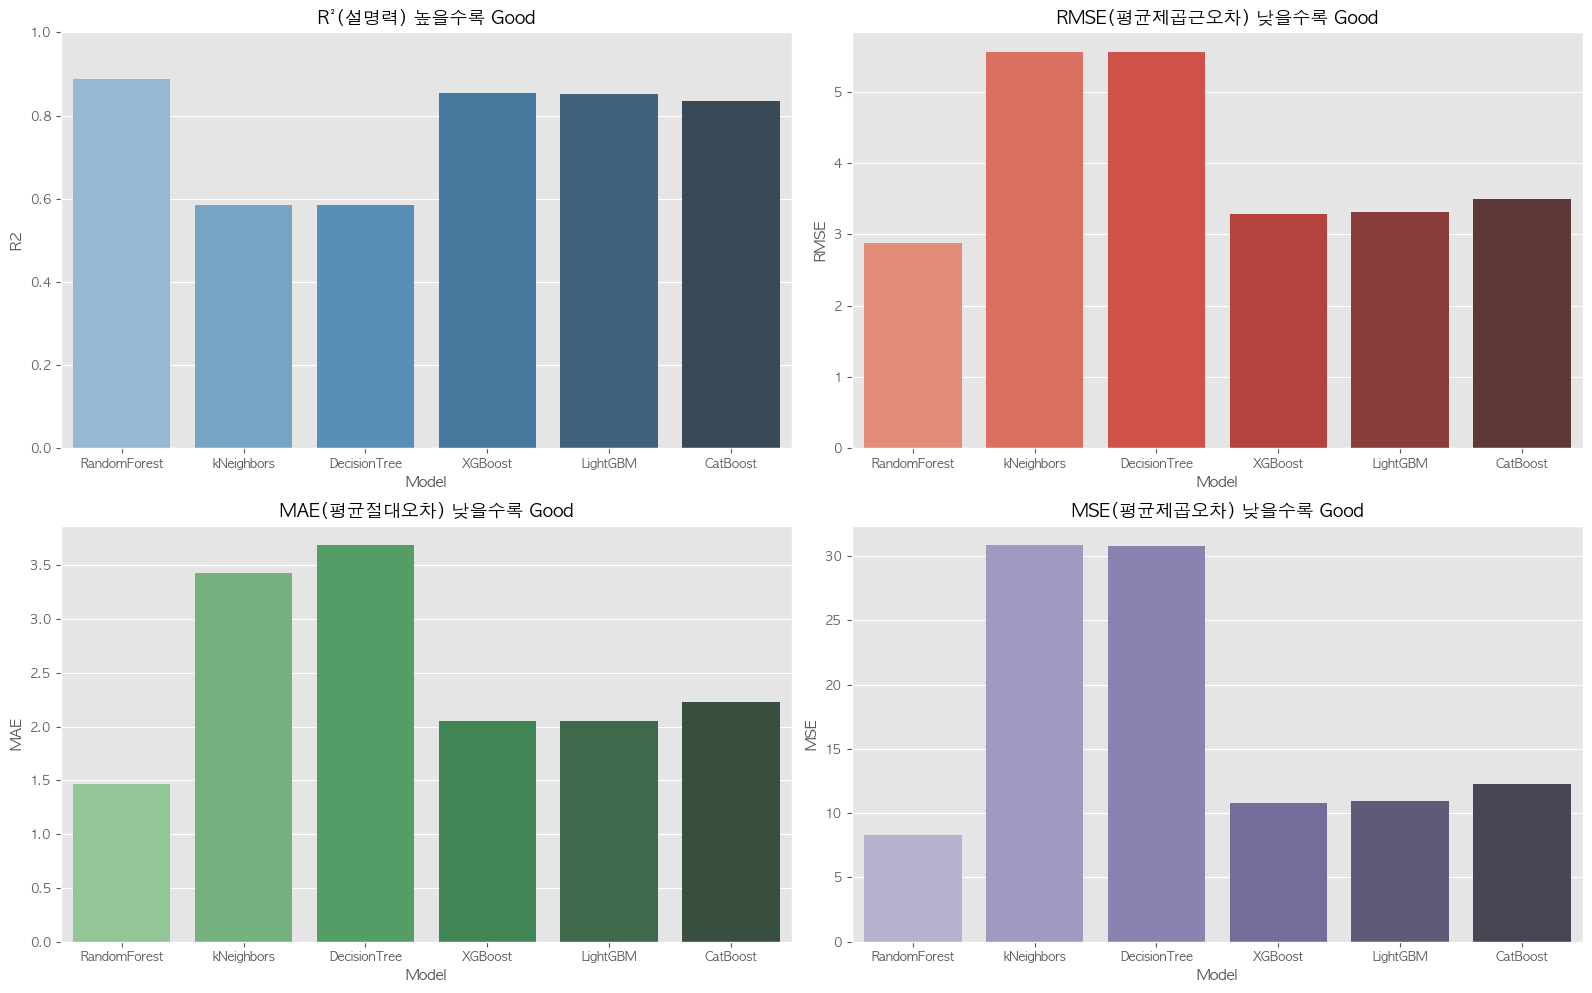

In [14]:
# 모델별 성능 데이터 입력 (네 결과를 그대로 사용)
results = {
    'Model': ['RandomForest', 'kNeighbors', 'DecisionTree', 'XGBoost', 'LightGBM', 'CatBoost'],
    'R2': [0.8881, 0.5841, 0.5844, 0.8543, 0.8518, 0.8345],
    'RMSE': [2.8795, 5.5514, 5.5489, 3.2861, 3.3136, 3.5013],
    'MAE': [1.4681, 3.4277, 3.6854, 2.0521, 2.0553, 2.2330],
    'MSE': [8.2917, 30.8176, 30.7905, 10.7985, 10.9797, 12.2589]
}

df = pd.DataFrame(results)

# df_melt = df.melt(id_vars='Model', value_vars=['R2', 'RMSE', 'MAE', 'MSE'],
#                   var_name='Metric', value_name='Score')


# 1. 폰트 설정 (애플고딕, macOS)
plt.rcParams['font.family'] = 'AppleGothic'   
plt.rcParams['font.size'] = 9                 
plt.rcParams['axes.unicode_minus'] = False    
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# R2
sns.barplot(x='Model', y='R2', data=df, ax=axes[0,0], palette='Blues_d')
axes[0,0].set_title('R²(설명력) 높을수록 Good')
axes[0,0].set_ylim(0, 1)

# RMSE
sns.barplot(x='Model', y='RMSE', data=df, ax=axes[0,1], palette='Reds_d')
axes[0,1].set_title('RMSE(평균제곱근오차) 낮을수록 Good')

# MAE
sns.barplot(x='Model', y='MAE', data=df, ax=axes[1,0], palette='Greens_d')
axes[1,0].set_title('MAE(평균절대오차) 낮을수록 Good')

# MSE
sns.barplot(x='Model', y='MSE', data=df, ax=axes[1,1], palette='Purples_d')
axes[1,1].set_title('MSE(평균제곱오차) 낮을수록 Good')

plt.tight_layout()
plt.show()